# Исследование данных сервиса проката самокатов Go Fast с проверкой стсатистических гипотез.

## Цели и задачи исследования

Из сервиса аренды самокатов GoFast нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках.

Цель исследования - необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Задачи:
1. провести подготовку данных для дальнейшего анализа (откорректировать форматы, устранить пропуски, обнаружить и устранить аномалии, проверить на дубликаты и т.д.);
2. провести исследовательский анализ даннных;
3. подготовить дополнительные столбцы и варианты датасетов для проверки статистических гипотез;
5. проверить 3 статистических гипотезы:
   - "Тратят ли пользователи с подпиской больше времени на поездки?"
   - "Превышает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, оптимальное расстояние 3130 метров или нет?"
   - "Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?"

Описание датасета users_go.csv:

- user_id:	уникальный идентификатор пользователя
- name:	имя пользователя
- age:	возраст
- city:	город
- subscription_type:	тип подписки (free, ultra)

Описание датасета rides_go.csv.

- user_id: уникальный идентификатор пользователя
- distance:	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration:	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date:	дата совершения поездки

Описание датасета subscription_go.csv: 
- subscription_type:	тип подписки
- minute_price:	стоимость одной минуты поездки по данной подписке
- start_ride_price:	стоимость начала поездки
- subscription_fee:	стоимость ежемесячного платежа

Импортируем библиотеки, которыми будем пользоваться в исследовании.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import factorial

## Предобработка данных
### Знакомство с данными

Загрузим и и проведем обзор датасетов.

- ***датасет 'users' - информация о пользователях сервиса***

In [2]:
try:
    users = pd.read_csv('/datasets/users_go.csv')
except:
    users = pd.read_csv('C:/Users/sutul/datasets/go_fast/users_go.csv')

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В датасете 'users' 4 столбца и 1565 строк. С типами данных всё в порядке.

***- датасет 'rides' - информация о поездках пользователей***

In [5]:
try:
    rides = pd.read_csv('/datasets/rides_go.csv')
except:
    rides = pd.read_csv('C:/Users/sutul/datasets/go_fast/rides_go.csv')

In [6]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В датасете 'rides' 3 столбца и 18068 строк. Требуется изменить перевести формат данных в столбце 'date' в формат даты-времени.

In [8]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y.%m.%d')

Также добавим столбец с месяцем поездки в датасет на основании данного столбца в соответствии с инструкцией к выполнению проекта.

In [9]:
rides['month'] = pd.DatetimeIndex(rides['date']).month

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b> 
<br>Новый столбец создан верно!
</div>

***- датасет 'subscriptions' - описание тарифов сервиса***

In [10]:
try:
    subscrs = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    subscrs = pd.read_csv('C:/Users/sutul/datasets/go_fast/subscriptions_go.csv')

In [11]:
subscrs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [12]:
subscrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В датасете 'subscriptions' всего 3 столбца и 2 строки. Изменение типов данных не требуется.

### Пропуски

In [13]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Пропуски в датасете 'users' отсутствуют.

In [14]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Пропуски в датасете 'rides' отсутствуют. Датасет 'subscriptions' проверять не будем, там всего 2 строки.

### Дубликаты

In [15]:
print('явных дубликатов -', users.duplicated().sum())
print('явных дубликатов -', rides.duplicated().sum())

явных дубликатов - 31
явных дубликатов - 0


В датасете 'users' 31 дубликат. Удаляем явные дубликаты.

In [16]:
users = users.drop_duplicates()

In [17]:
print('явных дубликатов -', users.duplicated().sum())

явных дубликатов - 0


### Наименования

Пройдемся по наименованиям категориальных значений. В датасете 'users' таковыми являются данные в столбцах 'city' и 'subscription_type':

In [18]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [19]:
users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

Наименования категориальных значений в датасете 'users' указаны без ошибок.

В датасетах 'rides' и 'subscriptions' категориальные значения отсутствуют.

### Аномалии

Проверим столбцы в датасетах на аномальные значения (нулевые, отрицательные - если они не подразумеваются, а также на слишком большие или слишкком маленькие). Построим гистограммы распределения значений по всем численным столбцам датасетов.

#### Датасет 'users'

В датасете 'users' необходимо проверить один столбец - 'age' возраст. Построим гистограмму стандартным методом hist().

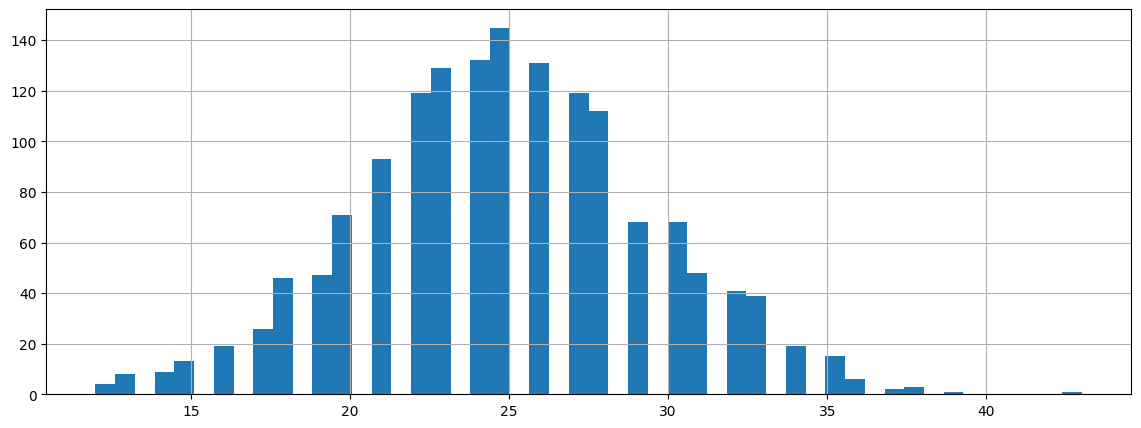

In [20]:
users['age'].hist(bins=50, figsize=(14,5));

На первый взгляд распределение данных имеет четкую куполовидную форму нормального распределения. Посмотрим присутствуют ли выбросы значений.

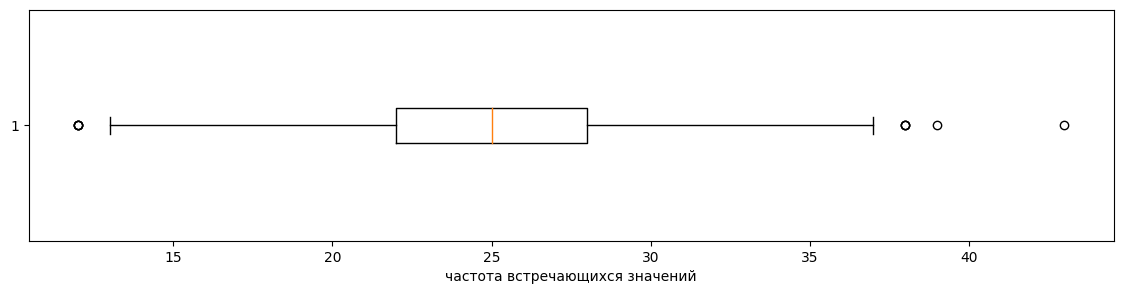

In [21]:
f, ax = plt.subplots(figsize=(14, 3))
ax.boxplot(x=users['age'], vert=False)
ax.set(ylabel="", xlabel="частота встречающихся значений");

Выбросы значений пристутствуют, однако они не аномальные, вполне себе можно представить пользователей сервиса проката самокатов возрастом 12 лет или 37-45 лет. Таким образом, строки с данными выбросами удалять не будем.

#### Датасет 'rides'

В датасете 'rides' необходимо проверить столбцы 'distance' и 'duration' на выбросы, нулевые и отрицательные значения. Столбец 'date' проверим на наличие аномальных значений даты и времени, не относящихся к основному объему данных. 

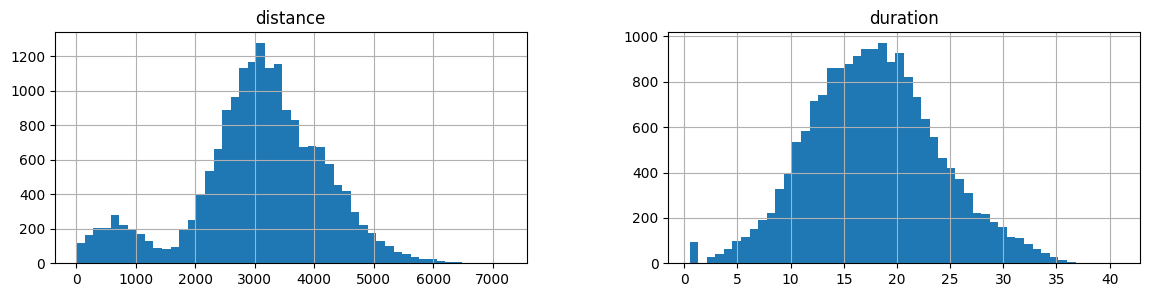

In [22]:
rides[{'distance', 'duration'}].hist(bins=50, figsize=(14,3));

Аномально высоких или отрицательных значений не наблюдается, нулевых значений - тоже. Однако распределение значений в столбце 'distance' имеет странный провал в районе 1500.

Предположим, что такое распределение данных обусловлено тем, что в датасете присутствует информация по различным городам, которые отличаются по размерам и разветвленности транспортной сети. Добавим в датасет 'rides' данные о городе, соединив его с датасетом 'users' и построим boxplot() для обоих наборов данных.

In [23]:
rides_users = rides.merge(users, on='user_id', how='left')

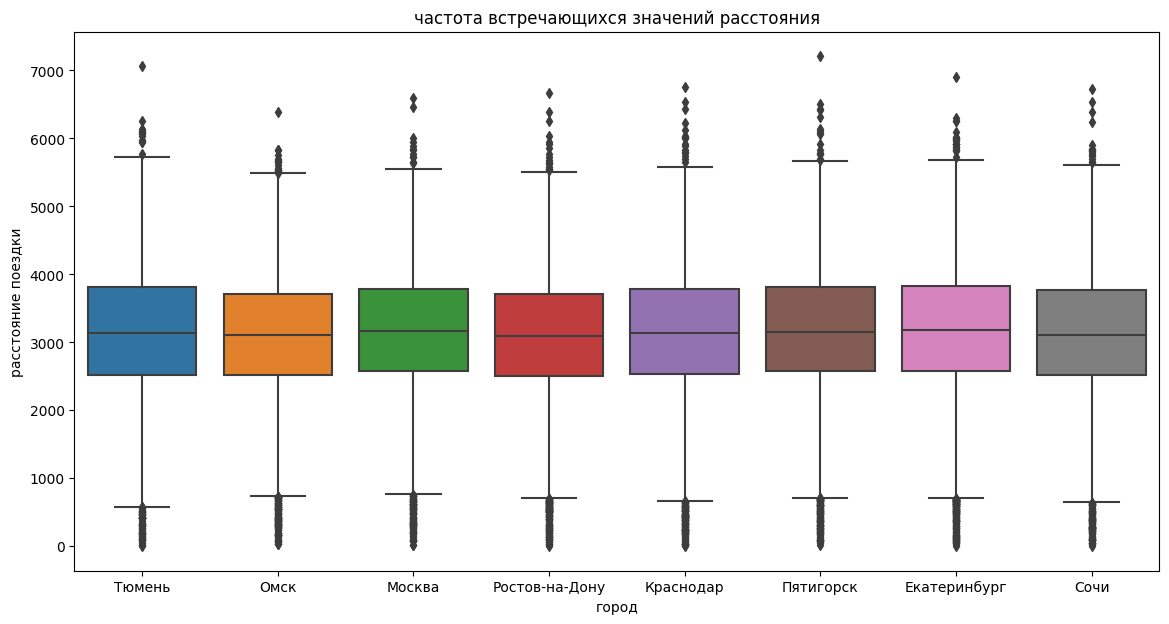

In [24]:
plt.subplots(figsize=(14, 7))
sns.boxplot(data=rides_users, x="city", y="distance")
plt.title("частота встречающихся значений расстояния")
plt.xlabel('город')
plt.ylabel('расстояние поездки');

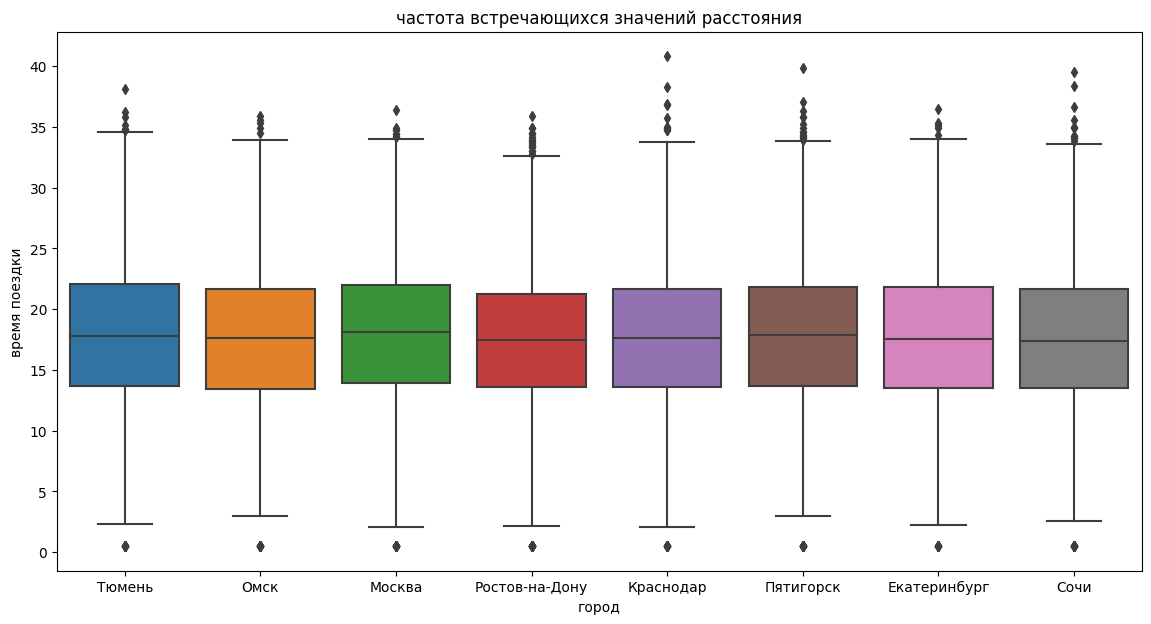

In [25]:
plt.subplots(figsize=(14, 7))
sns.boxplot(data=rides_users, x="city", y="duration")
plt.title("частота встречающихся значений расстояния")
plt.xlabel('город')
plt.ylabel('время поездки');

Как ни странно расстояние и продолжительность поездки не отличаются от города к городу существенно, не смотря на различную инфраструктуру городов. При этом незначительные выбросы присутствуют в каждом из случаев, однако слишком выбивающихся значений не наблюдается, оставим все значения и не будем их удалять.

Не забудем проверить нет ли в датасете аномальных значений даты-времени. Для этого, к примеру, построим диаграмму рассеяния методом scatterplot().

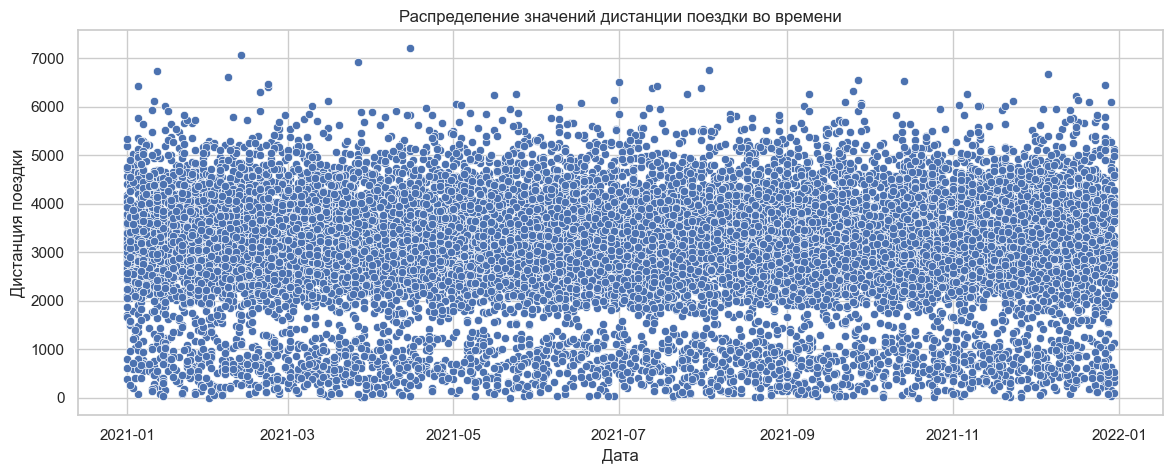

In [26]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 5))
sns.scatterplot(x='date', y='distance', data=rides)
ax.set_title('Распределение значений дистанции поездки во времени')
ax.set(ylabel="Дистанция поездки", xlabel="Дата");

Аномальные значения даты в датасете отсутствуют, понимаем теперь, что мы имеем для анализа данные сервиса за один календарный год - 2021.
Также на диаграмме рассеяния видно, что данные до 1500 м присутствуют на всем протяжении датасета, таким образом "провал" на гистограмме значений расстояний также не зависит и от даты. 

### Выводы по предобработке данных

- пропуски в данных отстуствуют;
- обнаружен и удален 31 дубликат в датасете 'users';
- наменования категориальных переменных заданы корректно;
- в датасете 'rides' изменен тип данных в столбце 'date', также добавлен столбец с месяцем поездки в соответствии с инструкцией к проекту;
- в датасетах 'users' и 'rides' аномалии отсутствуют, присутствуют выбросы значений, которые не сильно выбиваются из общей картины;
- гистограмма распределения данных столбца 'distance' в датасете 'rides' имеет два "купола" (малый - на значениях до 1,5км и большой - на значениях более 1,5км), при этом от города к городу данная кртина отличается незначительно.

## Исследовательский анализ данных
### Частота встречаемости городов


Попробуем посмотреть какие города встречаются чаще в датасете 'users'. Для отображения данной информации нам подойдет столбчатая диаграмма. Посчитаем частоту встречаемости данных по городу методом value_counts().

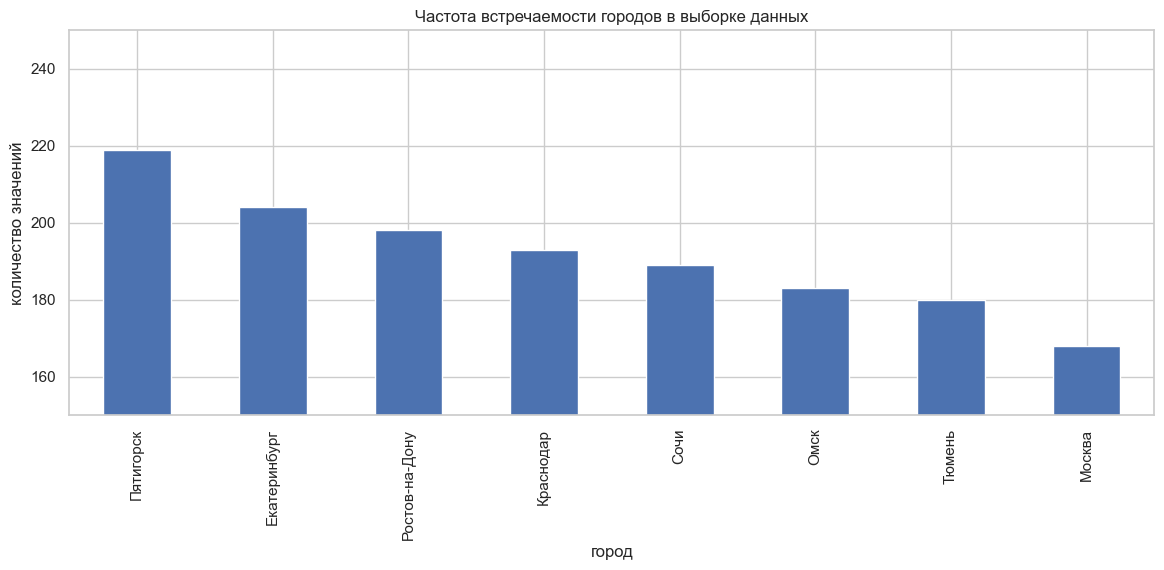

In [27]:
users['city'].value_counts().plot(kind='bar', figsize=(14,5), ylim=(150, 250))
plt.title('Частота встречаемости городов в выборке данных')
plt.xlabel('город')
plt.ylabel('количество значений');

Кто бы мог подумать, но "лидер" - Пятигорск, а Москва на последнем месте.

### Соотношение пользователей с подпиской и без

Посмотрим каких пользователей больше - с подпиской или без.

In [28]:
free_ultra = (
    users.pivot_table(index='city',
                      values='user_id',
                      columns='subscription_type',
                      aggfunc='count',
                      margins=True)
    .sort_values(by='All', ascending=False).reset_index()
)
free_ultra

subscription_type,city,free,ultra,All
0,All,835,699,1534
1,Пятигорск,125,94,219
2,Екатеринбург,112,92,204
3,Ростов-на-Дону,109,89,198
4,Краснодар,112,81,193
5,Сочи,103,86,189
6,Омск,92,91,183
7,Тюмень,98,82,180
8,Москва,84,84,168


Пользователей с подпиской меньше во всех случаях кроме Москвы - там поровну. Визуализируем полученные результаты в %. 

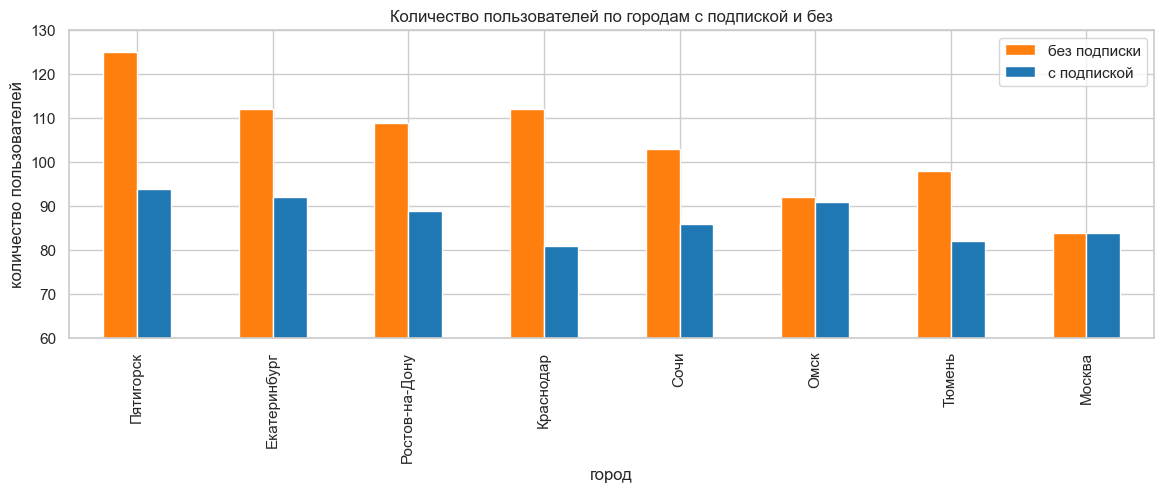

In [29]:
bar_colors = ['tab:orange', 'tab:blue']
free_ultra.drop(columns='All').drop(labels=0).plot(x='city', grid=True, kind='bar', figsize=(14,4), ylim=(60, 130), color=bar_colors)
plt.title('Количество пользователей по городам с подпиской и без')
plt.xlabel('город')
plt.ylabel('количество пользователей')
plt.legend(['без подписки', 'с подпиской'], title='');

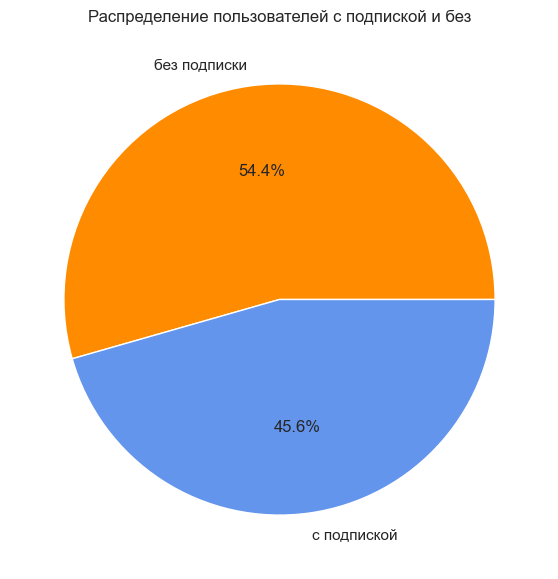

In [30]:
plt.figure(figsize=(7, 7))
users['subscription_type'].value_counts().plot(kind='pie', 
                                               autopct='%1.1f%%', 
                                               labels=['без подписки', 'с подпиской'], 
                                               colors=['darkorange', 'cornflowerblue'])
plt.title('Распределение пользователей с подпиской и без')
plt.ylabel('');

Пользователей без подписки больше, чем пользователей с подпиской. 

### Возраст пользователей

В п.2.5.1 мы уже визуализировали распределение возраста пользователей. Методом describe() выведем основные параметры распределения.

In [31]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Минимальный возраст - 12 лет, максимальный - 43. Медианный и средний возраст практически совпадают - 25 лет.

### Расстояние, которое пользователь преодолел за поездку

Вернемся к рассмотренному ранее распределению данной величины

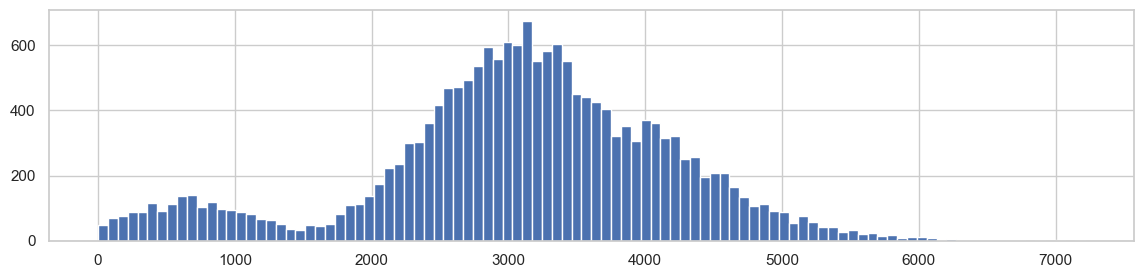

In [32]:
rides['distance'].hist(bins=100, figsize=(14,3));

In [33]:
rides_users['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Среднестатистический пользователь преодолевает порядка 3,1 километра за одну поездку.

Для интереса найдем топ-15 пользователей по среднему расстоянию поездки. 

In [34]:
rides_users.pivot_table(index={'name', 'city'}, values='distance', aggfunc={'median', 'count'}).sort_values(by='median', ascending=False).head(15)

count       median
city           name                      
Екатеринбург   Алиса       7  4395.430303
Пятигорск      Амалия      9  4331.893867
Сочи           Роберт      3  4168.277879
Москва         Эмиль      10  4106.022489
Екатеринбург   Петр       11  4049.233329
               Борис      13  4007.718541
Ростов-на-Дону Инна        8  3990.403646
Омск           Мирон      10  3963.677669
Ростов-на-Дону Борис      16  3955.882413
Москва         Олеся       4  3941.088726
Краснодар      Данила     12  3938.920958
Сочи           Арсен      18  3897.297322
Пятигорск      Дамир      18  3887.763269
Сочи           Самира      5  3875.924113
Москва         Милана     15  3857.812403

Алиса из Екатеринбурга наездила за 7 поездок большк всех.

### Продолжительность поездок

Проанализируем как расстояние коррелируется с продолжительностью поездки - прямая ли здесь зависимость.

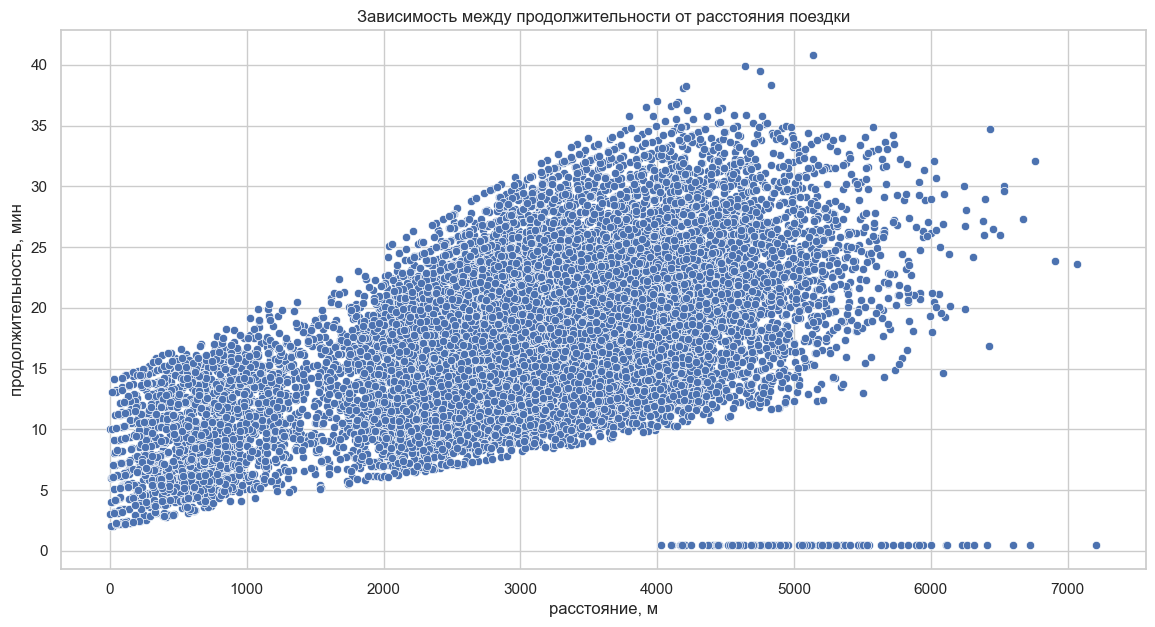

In [35]:
plt.figure(figsize=(14, 7))
g = (
    sns.scatterplot(
    x="distance", 
    y="duration",
    data=rides)
)
g.set(ylabel = 'продолжительность, мин', xlabel='расстояние, м')
g.set(title='Зависимость между продолжительности от расстояния поездки');

Зависимость прямая - чем дольше поездка, тем большее расстояние преодолевается.

In [36]:
rides_users['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

В среднем продолжительность поездки составляет около 18 минут. По аналогии с расстоянием выведем топ-15 пользователей по продолжительности поездок.

In [37]:
rides_users.pivot_table(index={'name', 'city'}, values='duration', aggfunc={'median', 'count'}).sort_values(by='median', ascending=False).head(15)

count     median
city           name                      
Москва         Роман         3  29.983174
Омск           Василиса      4  26.009244
Сочи           Самира        5  25.141404
Екатеринбург   Агата         5  25.099211
Тюмень         Мелания      10  24.674938
Сочи           Богдан        8  24.298553
Ростов-на-Дону Ева          13  23.597697
               Эмиль         8  23.288291
Екатеринбург   Ясмина        9  22.898791
Сочи           Платон       14  22.825576
Тюмень         Даниил        5  22.753041
Омск           Таисия        5  22.709766
Москва         Марина        7  22.451947
Екатеринбург   Марина       13  22.445493
Ростов-на-Дону Андрей       10  22.409494

### Выводы по исследовательскому анализу данных

- Тройка лидеров по количеству пользователей: Пятигорск, Екатеринбург, Ростов-на-Дону, Москва замыкает список. Сервис прокатов Go Fast более известен в регионах, в Москве не так популярен.
- Среднее распределение пользователей: 54.4% не пользуются платной подпиской, 45.6% - пользуются;
- Среднее расстояние поездки - 3,1км;
- Среднее время поездки - около 18 минут.

## Объединение данных

### Данные о пользователях, поездках и подписках

Данные о пользователях и поездках были объединены ранее, дополним датасет rides_users информацией о подписках, точнее стоимостью по типу подписки.

In [38]:
rides_users_subscrs = rides_users.merge(subscrs, on='subscription_type', how='left')
rides_users_subscrs.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Информация из 3-х датасетов сведена в один.

### Создание дополнительных датасетов

Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:

- c данными о пользователях без подписки;

- с данными о пользователях с подпиской.

In [39]:
rides_users_free = rides_users_subscrs[(rides_users_subscrs['subscription_type'] == "free")]
rides_users_ultra = rides_users_subscrs[(rides_users_subscrs['subscription_type'] == "ultra")]

In [40]:
rides_users_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int64         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


In [41]:
rides_users_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

### Визуализации

Посмотрим на обе категории по среднестатистическим параметрам расстояния и времени поездок. Сначала в разрезе городов, затем итого.

In [42]:
cities_free = rides_users_free.pivot_table(index='city', values={'distance', 'duration'}, aggfunc='median').reset_index()
cities_ultra = rides_users_ultra.pivot_table(index='city', values={'distance', 'duration'}, aggfunc='median').reset_index()
cities_free.columns = ['город', 'расстояние БЕЗ подписки', 'время БЕЗ подписки']
cities_ultra.columns = ['город', 'расстояние С подпиской', 'время С подпиской']
cities_all = cities_free.merge(cities_ultra, on='город')

In [43]:
cities_all

,город,расстояние БЕЗ подписки,время БЕЗ подписки,расстояние С подпиской,время С подпиской
0,Екатеринбург,3190.944857,17.359877,3179.287773,17.891909
1,Краснодар,3126.109285,17.411557,3150.135068,17.896091
2,Москва,3167.690944,17.744471,3152.322124,18.610855
3,Омск,3035.223693,17.169001,3147.436673,18.278488
4,Пятигорск,3179.852437,17.557427,3152.298459,18.332813
5,Ростов-на-Дону,3054.369333,17.282069,3134.361969,17.893428
6,Сочи,3041.225039,16.892949,3133.334634,18.082405
7,Тюмень,3117.056852,17.397465,3143.897717,18.284713


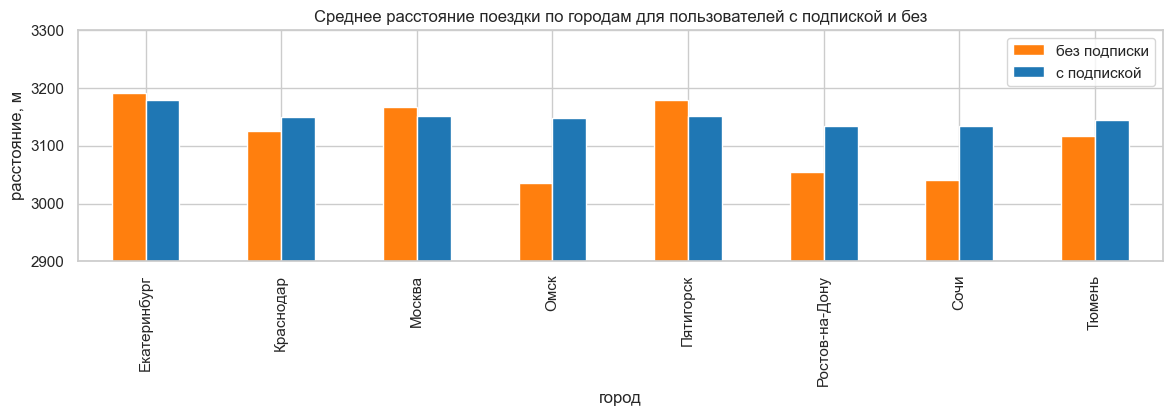

In [44]:
bar_colors = ['tab:orange', 'tab:blue']
cities_all.plot(x='город', y=['расстояние БЕЗ подписки', 'расстояние С подпиской'],
                grid=True, kind='bar', figsize=(14, 3), ylim=(2900, 3300), color=bar_colors)
plt.title('Среднее расстояние поездки по городам для пользователей с подпиской и без')
plt.xlabel('город')
plt.ylabel('расстояние, м')
plt.legend(['без подписки', 'с подпиской'], title='');

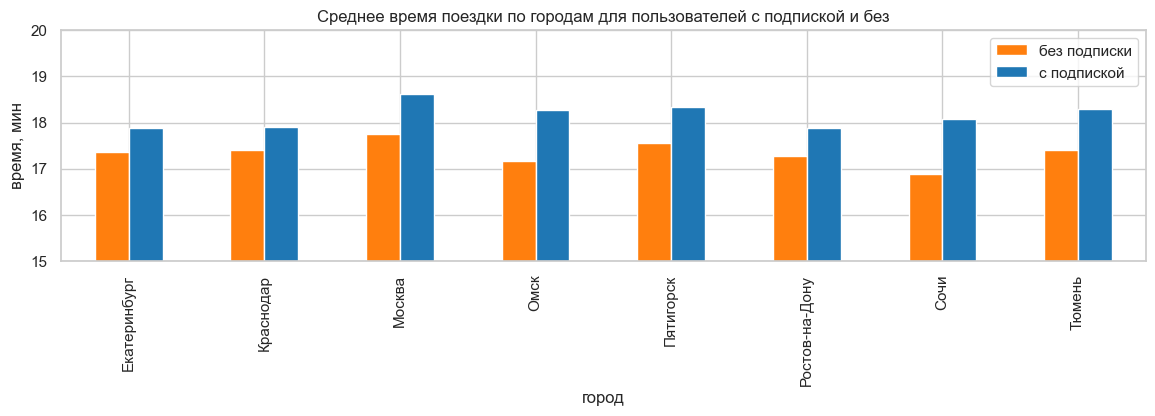

In [45]:
bar_colors = ['tab:orange', 'tab:blue']

cities_all.plot(x='город', y=['время БЕЗ подписки', 'время С подпиской'],
                grid=True, kind='bar', figsize=(14, 3), ylim=(15, 20), color=bar_colors)
plt.title('Среднее время поездки по городам для пользователей с подпиской и без')
plt.xlabel('город')
plt.ylabel('время, мин')
plt.legend(['без подписки', 'с подпиской'], title='');

Исходя из диаграмм можно сделать следующие выводы:
- пользователи с подпиской ездят однозначно дольше и, преимущественно, на более дальние расстояния;
- пользователи без подписки в Екатеринбурге, Москве и Пятигорске ездят на более длинные дистанции.

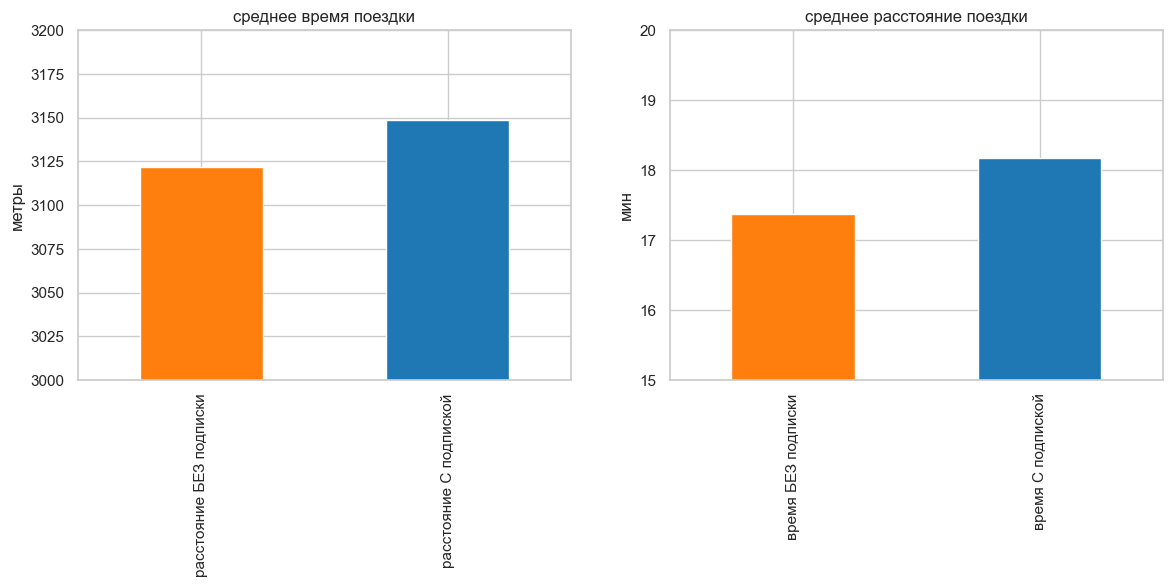

In [46]:
plt.figure(figsize=(14, 10))
bar_colors = ['tab:orange', 'tab:blue']

ax1 = plt.subplot(2, 2, 1)
(
cities_all[{'город' , 'расстояние БЕЗ подписки', 'расстояние С подпиской'}].median().sort_values()
.plot(grid=True, kind='bar', color=bar_colors, ylim=(3000, 3200))
)
plt.ylabel('метры')
plt.title('среднее время поездки')

ax2 = plt.subplot(2, 2, 2)
(
cities_all[{'город' , 'время БЕЗ подписки', 'время С подпиской'}].median().sort_values()
.plot(grid=True, kind='bar', color=bar_colors, ylim=(15, 20))
)
plt.ylabel('мин')
plt.title('среднее расстояние поездки');

В среднем продолжительность поездки и расстояние поездки у пользователей с подпиской больше.

In [47]:
cities_all[{'город' , 'расстояние БЕЗ подписки', 'расстояние С подпиской'}].median()

расстояние БЕЗ подписки    3121.583068
расстояние С подпиской     3148.785870
dtype: float64

In [48]:
cities_all[{'город' , 'время БЕЗ подписки', 'время С подпиской'}].median()

время БЕЗ подписки    17.378671
время С подпиской     18.180447
dtype: float64

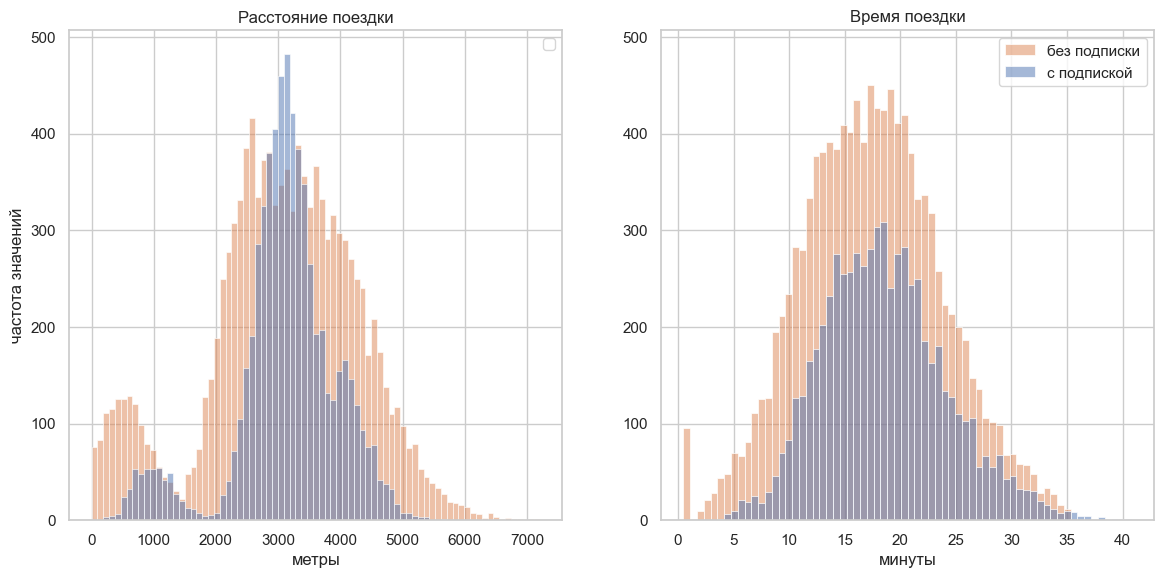

In [49]:
plt.figure(figsize=(14, 14))

ax1 = plt.subplot(2, 2, 1)
ax1 = sns.histplot(data=rides_users_subscrs, x="distance", hue="subscription_type")
ax1.set_title('Расстояние поездки')
ax1.set(ylabel="частота значений", xlabel="метры")
ax1.legend('')

ax2 = plt.subplot(2, 2, 2, sharey = ax1)
ax2 = sns.histplot(data=rides_users_subscrs, x="duration", hue="subscription_type")
ax2.set_title('Время поездки')
ax2.set(ylabel="", xlabel="минуты")
ax2.legend(['без подписки', 'с подпиской'], title='');

Если также посмотреть на распределение расстояния и времени поездки с разбивкой по видам подписки пользователей, то можно заметить интересную деталь - при поездках около 3 км пользователи без подписки ездят больше, таким образом можно сформулировать следующие выводы по данному разделу проекта:
- среднее расстояние и время поездки различаются от города, но в среднем пользователи с подпиской ездят дольше и дальше;
- трехкилометровые дистанции чаще преодолевают пользователи без подписки, вероятно это оптимальное расстояние с точки зрения расходов на поездку с учетом скорости самоката. 

## Подсчёт выручки
### Распределение поездок по месяцам

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [50]:
rides_users_subscrs['duration'] = np.ceil(rides_users_subscrs['duration'])
month_rides = (
                rides_users_subscrs.pivot_table(index=['subscription_type', 'month', 'user_id'], 
                                              values=['distance', 'date', 'duration'],
                                              aggfunc={'distance': 'sum', 'date': 'count', 'duration': 'sum'})
                .reset_index()
)
month_rides.head(10)

,subscription_type,month,user_id,date,distance,duration
0,free,1,700,1,2515.690719,15.0
1,free,1,701,1,2676.472894,18.0
2,free,1,702,1,903.861985,16.0
3,free,1,703,1,3406.580225,24.0
4,free,1,704,1,3197.139639,18.0
5,free,1,706,2,7443.193197,37.0
6,free,1,707,2,7857.433223,44.0
7,free,1,709,1,3368.357750,25.0
8,free,1,711,3,9508.637968,61.0
9,free,1,712,1,2235.247794,19.0


### Распределение выручки по месяцам

Сделаем аналогичный датафрейм с помесячной выручкой, которую принёс каждый пользователь. Необходимо учесть, что каждый пользовательь в разное время мог как пользоваться подпиской, так и нет. Сначала добавим в исходный общий датасет столбец с выручкой, рассчитанной по продолжительности поездки + тариф за начало поездки. 

In [51]:
min_free = 8
min_ultra = 6
start = 50
ultra = 199
revenue = []
for i in month_rides.itertuples():
    if i[1] == 'free':
        revenue.append(start*i[4] + i[6]*min_free)
    else:
        revenue.append(ultra + i[6]*min_ultra)
month_rides['revenue'] = revenue
month_rides

,subscription_type,month,user_id,date,distance,duration,revenue
0,free,1,700,1,2515.690719,15.0,170.0
1,free,1,701,1,2676.472894,18.0,194.0
2,free,1,702,1,903.861985,16.0,178.0
3,free,1,703,1,3406.580225,24.0,242.0
4,free,1,704,1,3197.139639,18.0,194.0
...,...,...,...,...,...,...,...
11326,ultra,12,688,1,4004.404223,24.0,343.0
11327,ultra,12,689,1,3387.343067,19.0,313.0
11328,ultra,12,692,1,2947.000211,15.0,289.0
11329,ultra,12,694,1,3591.099488,18.0,307.0


## Проверка гипотез
### Продолжительность поездки

Важно понять, тратят ли пользователи с подпиской больше времени на поездки. Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Сначала сформулируем нулевую и альтернативную гипотезы:
- нулевая гипотеза: пользователи с подпиской тратят столько же времени на поездки, сколько и пользователи без подписки.
- альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

Имеем дело с "правосторонней" гипотезой. 

In [52]:
duration_ultra = rides_users_ultra['duration']
duration_free = rides_users_free['duration']

alpha = 0.01 # уровень статистической значимости

results = st.ttest_ind(
    duration_ultra, 
    duration_free,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


Значение "p" очень маленькое, соответственно мы отвергаем нулевую гипотезу, принимаем альтернативную - пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. Это мы также видели при обзоре среднестатистических величин в разделе 4.

### Расстояние поездки

Производитель самокатов утверждает, что расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Необходимо проверить, превышает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, оптимальное расстояние 3130 метров или нет.

Сформулируем нулевую и альтернативную гипотезы:
- нулевая гипотеза: пользователи с подпиской проезжают оптимальное расстояние.
- альтернативная гипотеза: пользователи с подпиской проезжают больше оптимального расстояния.

Имеем дело также с "правосторонней" гипотезой. 

In [53]:
distance_ultra = rides_users_ultra['distance']
opt_distance = 3130

alpha = 0.01 # уровень статистической значимости

results = st.ttest_1samp(
    distance_ultra, 
    opt_distance,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Значение "p" достаточно большое, чтобы с уверенностью сказать, что пользователи с подпиской проезжают оптимальное с точки зрения износа самоката расстояние.

### Помесячная выручка

Проверим гипотезу будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Сформулируем нулевую и альтернативную гипотезы:
- нулевая гипотеза: выручка от пользователи с подпиской по месяцам не превышает выручку от пользователей без подписки.
- альтернативная гипотеза: выручка от пользователи с подпиской по месяцам превышает выручку от пользователей без подписки.

Имеем дело также с "правосторонней" гипотезой. 

In [54]:
revenue_ultra = month_rides.query('subscription_type == "ultra"')['revenue']
revenue_free = month_rides.query('subscription_type == "free"')['revenue']

alpha = 0.01 # уровень статистической значимости

results = st.ttest_ind(
    revenue_ultra, 
    revenue_free,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Значение "р" очень маленькое, соответственно отвергаем нулевую гипотезу и принимаем альтернативную - выручка от пользователи с подпиской по месяцам превышает выручку от пользователей без подписки.

### Обращения в техподдержку

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.

В данном случае мы будем проверять гипотезу о равенстве среднего значения генеральной совокупности до и после изменения, будем проверять равенство средних для зависимых (парных) выборок, используя метод **scipy.stats.ttest_rel**.

## Выводы по результатам исследования

1. В данной работе проведена подготовка данных для дальнейшего анализа в том числе откорректированы форматы, устранены пропуски, обнаружены и устранены аномалии, проведена проверка на дубликаты и т.д. Основной объем предобработки заняла "чистка" датасетов от аномальных значений-выбросов, по результатам которых 6,7% датасета пришлось удалить.
2. После предподготовки датасетов с данными проанализированы:
   - частота встречаемости городов;
   - распределение пользователей по видам подписки;
   - возраст пользователей;
   - расстояние и продолжительность поездки.
3. Основные выводы по исследовательскому анализу данных:
   - Тройка лидеров по количеству пользователей: Пятигорск, Екатеринбург, Ростов-на-Дону, Москва замыкает список. Сервис прокатов Go Fast более известен в регионах, в Москве не так популярен.
   - Пользователей с подпиской меньше (45.6%), чем без неё (54.4%);
   - Среднее расстояние поездки - 3,1км, время поездки - около 18 минут;
4. Далее подготовлены дополнительные столбцы и варианты датасетов для проверки статистических гипотез. В процессе выполнения также построены визуализации, описывающие разделение пользователей по видам подписки. Выводы:
   - среднее расстояние и время поездки различаются от города, но в среднем пользователи с подпиской ездят дольше и дальше.
5. Проведена проверка 3-х статистических гипотез:
   - "Тратят ли пользователи с подпиской больше времени на поездки?" Ответ: Да. Пользователи с подпиской ездят больше.
   - "Превышает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, оптимальное расстояние 3130 метров или нет?" Ответ: Нет. Пользователи с подпиской проезжают оптимальное с точки зрения износа самоката расстояние 3130м.
   - "Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?" Ответ: Да. Выручка от пользователи с подпиской по месяцам превышает выручку от пользователей без подписки.